##### Read Dataset
* **Target**: The polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **IDs**: The ID of the tweet (e.g., 2087)
* **Date**: The date of the tweet (e.g., Sat May 16 23:58:44 UTC 2009)
* **Flag**: The query (e.g., lyx). If there is no query, then this value is NO_QUERY.
* **User**: The user that tweeted (e.g., robotickilldozr)
* **Text**: The text of the tweet (e.g., "Lyx is cool")

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('resources/data.csv', encoding='ISO-8859-1', header=None)

# Assign column names 
df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']

# Display the first few rows of the dataframe
df.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


##### Clean Dataset

* Remove unnecessary columns
* Remove rows with missing values
* Clean the text
* Map the target values

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Download stopwords if not already downloaded
nltk.download('stopwords')

def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters
    text = re.sub('[^a-z]', ' ', text)
    
    # Remove stopwords and stem the words
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    
    # Join the words back into a single string
    text = ' '.join(words)
    
    return text


# Remove unnecessary columns
df.drop(['id', 'date', 'query', 'user'], axis=1, inplace=True)

# Remove rows with missing values
df.dropna(inplace=True)

# Clean the text
df['text'] = df['text'].apply(clean_text)

# Map the target values to 0 (negative), 1 (neutral), and 2 (positive)
df['sentiment'] = df['sentiment'].map({0: 0, 2: 1, 4: 2})

print(f'unique sentiments: {df["sentiment"].unique()}')
print(f'shape after cleaning: {df.shape}')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lukal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


unique sentiments: [0 2]
shape after cleaning: (1600000, 2)


##### Visualize distribution

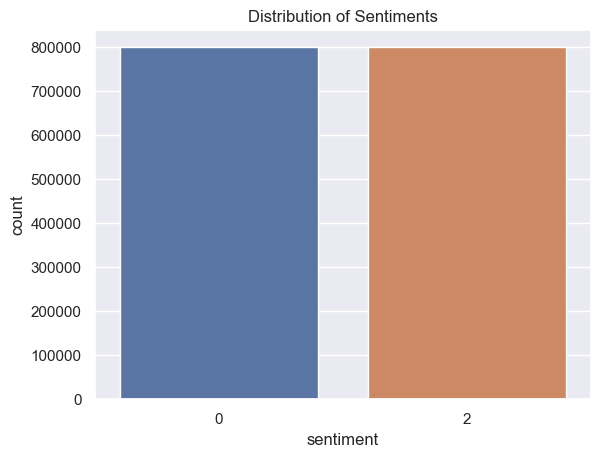

In [3]:
# visualize the distribution of sentiments

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn for our plot
sns.set(style="darkgrid")

# Create a countplot
sns.countplot(x='sentiment', data=df)

# Give the plot a title and show it
plt.title('Distribution of Sentiments')
plt.show()

##### Find most common words for each sentiment

In [4]:
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('punkt')

# Split the DataFrame by sentiment
df_negative = df[df['sentiment'] == 0]
df_neutral = df[df['sentiment'] == 1]
df_positive = df[df['sentiment'] == 2]

# Tokenize the tweets
tokens_negative = word_tokenize(' '.join(df_negative['text']))
tokens_neutral = word_tokenize(' '.join(df_neutral['text']))
tokens_positive = word_tokenize(' '.join(df_positive['text']))

# Count the words
counter_negative = Counter(tokens_negative)
counter_neutral = Counter(tokens_neutral)
counter_positive = Counter(tokens_positive)

# Find the most common words
common_words_negative = counter_negative.most_common(10)
common_words_neutral = counter_neutral.most_common(10)
common_words_positive = counter_positive.most_common(10)

# Print the most common words for each sentiment
print('Negative:', common_words_negative)
print('Neutral:', common_words_neutral)
print('Positive:', common_words_positive)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lukal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Negative: [('go', 79380), ('get', 61591), ('work', 59062), ('day', 52276), ('miss', 47944), ('like', 43272), ('want', 40287), ('got', 38930), ('today', 38373), ('feel', 36918)]
Neutral: []
Positive: [('good', 62892), ('love', 61130), ('go', 59425), ('day', 57135), ('thank', 51092), ('get', 49279), ('http', 47263), ('quot', 47001), ('like', 40578), ('lol', 36263)]


##### Converting text into numerical representation

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Fit and transform the 'text' column
tfidf_matrix = vectorizer.fit_transform(df['text'])

# tfidf_matrix is a sparse matrix where each row corresponds to a document in the original DataFrame,
# and the value in each cell is the TF-IDF score of a particular word in a particular document.
# Dense matrix required too much memory

##### Logistic regression model

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = tfidf_matrix
y = df['sentiment']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

classification_report(y_test, y_pred)


c:\Users\lukal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'              precision    recall  f1-score   support\n\n           0       0.79      0.75      0.77    159494\n           2       0.77      0.80      0.78    160506\n\n    accuracy                           0.78    320000\n   macro avg       0.78      0.78      0.78    320000\nweighted avg       0.78      0.78      0.78    320000\n'

### **Result interpretation**

Based on the classification report, our model has an accuracy of 78%. This means that it correctly predicts the sentiment of a tweet 78% of the time, which indicates a reasonably good performance.

The precision, recall, and F1-score for both classes (0 and 2) are also quite similar and close to the accuracy. This suggests that the model performs similarly well on both negative and positive tweets.

However, it's important to note that the model did not fully converge during training. This means that the results could potentially be improved by increasing the number of iterations or scaling the data.

### **Sentiment distribution**

The 'support' values in the classification report indicate the number of instances of each class in the test set. In this case, there are slightly more instances of class 2 (positive) than class 0 (negative). This suggests that positive sentiments are slightly more common in the dataset.

### **Predicting sentiment** 

The model's accuracy of 78% suggests that it's reasonably possible to predict sentiment based on a tweet's text. However, the performance could potentially be improved with further model tuning. 

### **Indicators of sentiment**

The TF-IDF vectorizer that we used to preprocess the text assigns higher values to words that are more important for distinguishing between documents. Therefore, words with high TF-IDF scores can be considered strong indicators of sentiment.

From the most common words in each sentiment category, we can observe some patterns:

* Negative Sentiment: Words like 'go', 'get', 'work', 'miss', and 'feel' are common in negative tweets. This suggests that tweets expressing negative sentiment often involve actions or emotions that are perceived negatively.

* Positive Sentiment: Words like 'good', 'love', 'thank', and 'lol' are common in positive tweets. This suggests that tweets expressing positive sentiment often involve positive emotions or reactions.

It's important to note that the presence of a particular word does not guarantee a specific sentiment. The context in which the word is used also plays a crucial role. However, these common words can give us a general idea of the language patterns associated with each sentiment.

